<a href="https://colab.research.google.com/github/uluumy/Fondements-de-l-apprentissage-profond/blob/master/Solution_Projet_ChatsChiens_Etape3_ApprentissageParTransfert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet: Chats vs Chiens
## Classification d'images: utilisation de modèle pré-entrainé (apprentissage par transfert)

##Étape 1: Mise en place de l'environnement


### Colab

Execution -> Reinitialiser tous les environnemetns d'execussion (lRuntime -> Reset all runtimes)

Execussion -> Modifier le type d'execussion -> Accelereateur materiel -> GPU


### Librairies à importer

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os  ## Pour lire les fichiers et la structure des répertoires
import matplotlib.pyplot as plt
import numpy as np

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.logging.set_verbosity(tf.logging.ERROR)

### Fonctions utiles

In [0]:
def plot_history(x,y1,y2,y1_label, y2_label, x_label, y_label,title):
  plt.clf()
  plt.plot(x, y1, label=y1_label) 
  plt.plot(x, y2, label=y2_label)
  
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.show

In [0]:
# CEtte fonction affiche l'image.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### Instantiation du modele pre-entraine (VGG16)

In [5]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Using TensorFlow backend.


58892288/58889256 [==============================] - 2s 0us/step


In [6]:

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## Étape 2: Obtention des données

### Importer

In [7]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 1s 0us/step


In [8]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [0]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

## Étape 3: Extraction des features

In [10]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


###Avoir les bonnes dimensions

In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))

## Étape 4: Création du modèle

### Définir le modèle

In [0]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

### Compiler le modèle

In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

### Sommaire du modèle

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


### Entrainer le modèle

In [29]:
EPOCHS = 5
history = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/5
2000/2000 [==============================] - 1s 278us/step - loss: 0.2601 - acc: 0.9055 - val_loss: 0.2915 - val_acc: 0.8750
Epoch 2/5
2000/2000 [==============================] - 1s 280us/step - loss: 0.2369 - acc: 0.9090 - val_loss: 0.2782 - val_acc: 0.8750
Epoch 3/5
2000/2000 [==============================] - 1s 277us/step - loss: 0.2317 - acc: 0.9065 - val_loss: 0.2710 - val_acc: 0.8800
Epoch 4/5
2000/2000 [==============================] - 1s 278us/step - loss: 0.2134 - acc: 0.9175 - val_loss: 0.2679 - val_acc: 0.8820
Epoch 5/5
2000/2000 [==============================] - 1s 270us/step - loss: 0.2038 - acc: 0.9220 - val_loss: 0.2657 - val_acc: 0.8810


### Visualisation des résultats

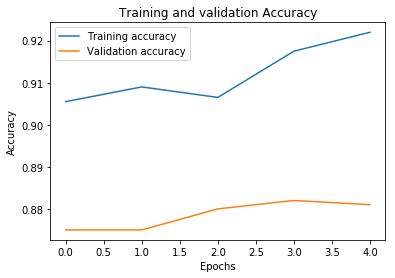

In [30]:

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']

epochs_range = range(EPOCHS)
val_loss = history.history['val_loss']
plot_history(epochs_range, acc, val_acc, 'Training accuracy', 'Validation accuracy', 'Epochs', 'Accuracy','Training and validation Accuracy')

In [31]:
print('train accuracy:', model.evaluate(train_features, train_labels)[1])

print('validation accuracy:', model.evaluate(validation_features, validation_labels)[1])

2000/2000 [==============================] - 0s 87us/step
train accuracy: 0.9455
1000/1000 [==============================] - 0s 81us/step
validation accuracy: 0.881


ressources
https://github.com/uluumy/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb


